In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [8]:
df = pd.read_csv('playerdata.csv')

In [9]:
df.sort_values(by='Market Value').head(10)

,Player,Overall Score,Potential Score,Market Value,Weekly Salary,Height,Weight,Age,Preferred Foot,Ball Skills,Defence,Mental,Passing,Physical,Shooting,Goalkeeping
7921,Jean-François Gillet,68,68,1000,2900,181,78,41,Left,18.0,16.333333,37.333333,26.666667,50.285714,20.750,68.8
12706,Leao Butrón,64,64,1000,1700,184,82,43,Right,15.0,20.000000,33.500000,22.333333,40.285714,17.000,62.6
13582,Hussain Omar Sulaimani,63,63,1000,4500,173,70,43,Left,63.5,63.666667,69.833333,68.333333,60.571429,59.125,13.0
3293,Cifuentes,73,73,1000,4000,189,80,41,Right,22.5,15.000000,37.333333,21.000000,47.142857,22.125,71.8
17278,Kevin Ellison,58,58,1000,1500,180,76,41,Left,62.5,37.000000,63.166667,53.000000,60.000000,63.125,8.8
9103,Robinson Zapata,67,67,1000,1500,184,85,41,Right,18.5,12.000000,40.166667,18.666667,44.285714,23.125,66.0
15427,Dannie Bulman,61,61,1000,1500,175,75,41,Right,60.0,57.333333,60.333333,57.333333,61.142857,45.750,13.4
9097,Mauricio Caranta,67,67,1000,2500,184,80,42,Right,12.0,12.666667,41.500000,18.000000,52.142857,17.875,66.2
6789,Lee Dong Gook,69,69,1000,4500,185,80,41,Right,60.0,20.333333,59.333333,59.000000,50.428571,75.750,9.6
4079,Cristian Lucchetti,72,72,1000,4500,182,74,42,Right,29.5,18.666667,40.166667,29.666667,46.571429,29.750,72.0


In [10]:
df = df[df['Market Value']!=1000]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19386 entries, 0 to 19401
Data columns (total 16 columns):
Player             19386 non-null object
Overall Score      19386 non-null int64
Potential Score    19386 non-null int64
Market Value       19386 non-null int64
Weekly Salary      19386 non-null int64
Height             19386 non-null int64
Weight             19386 non-null int64
Age                19386 non-null int64
Preferred Foot     19386 non-null object
Ball Skills        19386 non-null float64
Defence            19386 non-null float64
Mental             19386 non-null float64
Passing            19386 non-null float64
Physical           19386 non-null float64
Shooting           19386 non-null float64
Goalkeeping        19386 non-null float64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.5+ MB


In [12]:
df = pd.get_dummies(df,columns=['Preferred Foot'],drop_first=True)

In [13]:
df.drop(['Overall Score','Potential Score','Weekly Salary'],axis=1,inplace=True)

In [17]:
df.head()

,Player,Market Value,Height,Weight,Age,Ball Skills,Defence,Mental,Passing,Physical,Shooting,Goalkeeping,Preferred Foot_Right
0,Lionel Messi,95500000,170,72,33,96.5,32.000000,77.833333,90.666667,82.000000,86.875,10.8,0
1,Cristiano Ronaldo,58500000,187,83,35,90.5,28.000000,76.666667,81.333333,85.000000,87.500,11.6,1
2,Neymar Jr,105500000,175,68,28,95.5,31.333333,75.000000,85.000000,79.142857,83.750,11.8,1
3,Virgil van Dijk,90000000,193,92,29,73.5,90.666667,77.333333,71.666667,74.857143,65.125,11.6,1
4,Jan Oblak,77500000,188,87,27,21.0,19.000000,47.500000,32.000000,59.428571,18.500,87.2,1


In [15]:
df_show = df.copy()
df_show['Market Value'] = df_show['Market Value'].apply(lambda x : "{:,}".format(int(x)))
df_show[['Ball Skills','Defence','Mental','Passing','Physical','Shooting','Goalkeeping']] = df_show[['Ball Skills','Defence','Mental','Passing','Physical','Shooting','Goalkeeping']].apply(lambda x: round(x,1))
df_show = df_show.rename(columns={'Market Value':'Market Value (Euros)'})
df_show

,Player,Market Value (Euros),Height,Weight,Age,Ball Skills,Defence,Mental,Passing,Physical,Shooting,Goalkeeping,Preferred Foot_Right
0,Lionel Messi,"95,500,000",170,72,33,96.5,32.0,77.8,90.7,82.0,86.9,10.8,0
1,Cristiano Ronaldo,"58,500,000",187,83,35,90.5,28.0,76.7,81.3,85.0,87.5,11.6,1
2,Neymar Jr,"105,500,000",175,68,28,95.5,31.3,75.0,85.0,79.1,83.8,11.8,1
3,Virgil van Dijk,"90,000,000",193,92,29,73.5,90.7,77.3,71.7,74.9,65.1,11.6,1
4,Jan Oblak,"77,500,000",188,87,27,21.0,19.0,47.5,32.0,59.4,18.5,87.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19397,Li Xuebo,"30,000",188,75,20,10.0,9.7,22.5,16.3,33.0,12.2,46.4,1
19398,Cheng Hui,"35,000",178,70,23,44.0,44.7,43.5,43.7,58.0,35.5,7.4,1
19399,Yang Lei,"40,000",186,65,20,39.0,45.3,38.7,36.3,60.3,26.9,10.4,1
19400,Lee Jea Ho,"45,000",184,77,23,42.5,44.7,44.0,49.0,52.9,34.5,10.0,1


In [18]:
corr_matrix = df.corr()
corr_matrix

,Market Value,Height,Weight,Age,Ball Skills,Defence,Mental,Passing,Physical,Shooting,Goalkeeping,Preferred Foot_Right
Market Value,1.000000,0.017298,0.054666,0.089680,0.290153,0.131131,0.397547,0.316110,0.240531,0.308490,-0.019608,-0.014341
Height,0.017298,1.000000,0.770593,0.091229,-0.453066,-0.076761,-0.250526,-0.422412,-0.471272,-0.350490,0.365944,0.081536
Weight,0.054666,0.770593,1.000000,0.240969,-0.375437,-0.060867,-0.157335,-0.338656,-0.367878,-0.256137,0.340443,0.075401
Age,0.089680,0.091229,0.240969,1.000000,0.056025,0.120333,0.298238,0.155501,0.049629,0.176935,0.107408,0.000843
Ball Skills,0.290153,-0.453066,-0.375437,0.056025,1.000000,0.398669,0.824202,0.904782,0.817678,0.896761,-0.800917,-0.122817
Defence,0.131131,-0.076761,-0.060867,0.120333,0.398669,1.000000,0.663119,0.572625,0.413828,0.231936,-0.552226,-0.112041
Mental,0.397547,-0.250526,-0.157335,0.298238,0.824202,0.663119,1.000000,0.879150,0.724474,0.779073,-0.653487,-0.096049
Passing,0.316110,-0.422412,-0.338656,0.155501,0.904782,0.572625,0.879150,1.000000,0.751068,0.816722,-0.722302,-0.149937
Physical,0.240531,-0.471272,-0.367878,0.049629,0.817678,0.413828,0.724474,0.751068,1.000000,0.717404,-0.710023,-0.102524
Shooting,0.308490,-0.350490,-0.256137,0.176935,0.896761,0.231936,0.779073,0.816722,0.717404,1.000000,-0.684796,-0.088161


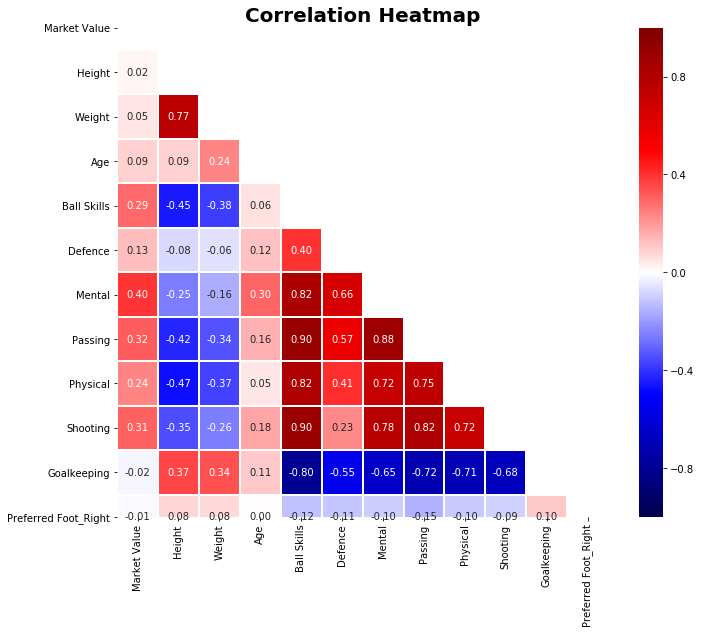

In [19]:
fig = plt.figure(figsize=[11,9])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20)

In [20]:
df = df.drop(['Height','Weight','Preferred Foot_Right'],axis=1)

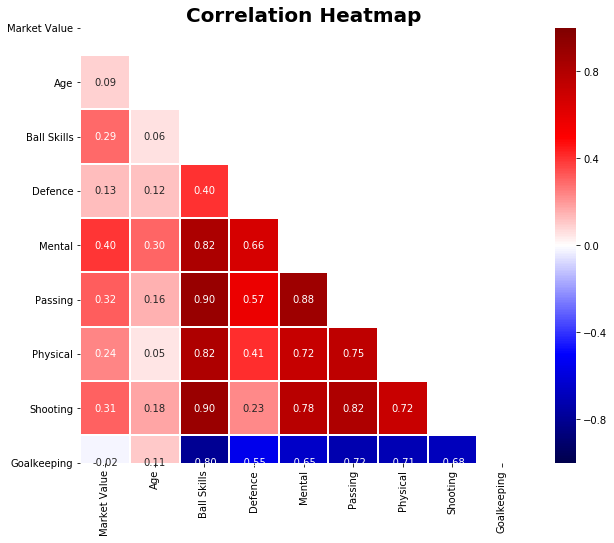

In [22]:
corr_matrix = df.corr()
fig = plt.figure(figsize=[10,8])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20)

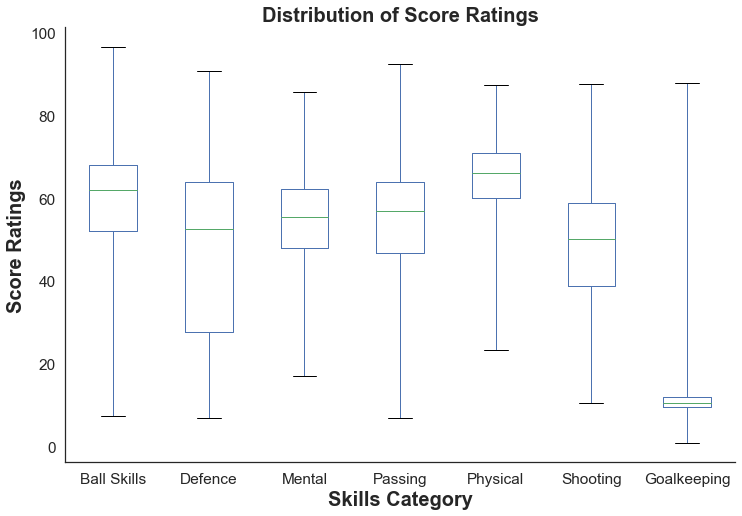

In [23]:
fig = plt.figure(figsize=[12,8])
sns.set(style = 'white', font_scale=1.4)
df[['Ball Skills','Defence','Mental','Passing','Physical','Shooting','Goalkeeping']].boxplot(whis='range')
plt.grid(False)
plt.xlabel('Skills Category',fontsize=20,weight='bold')
plt.ylabel('Score Ratings',fontsize=20,weight='bold')
plt.title('Distribution of Score Ratings',fontsize=20,weight='bold')
sns.despine()

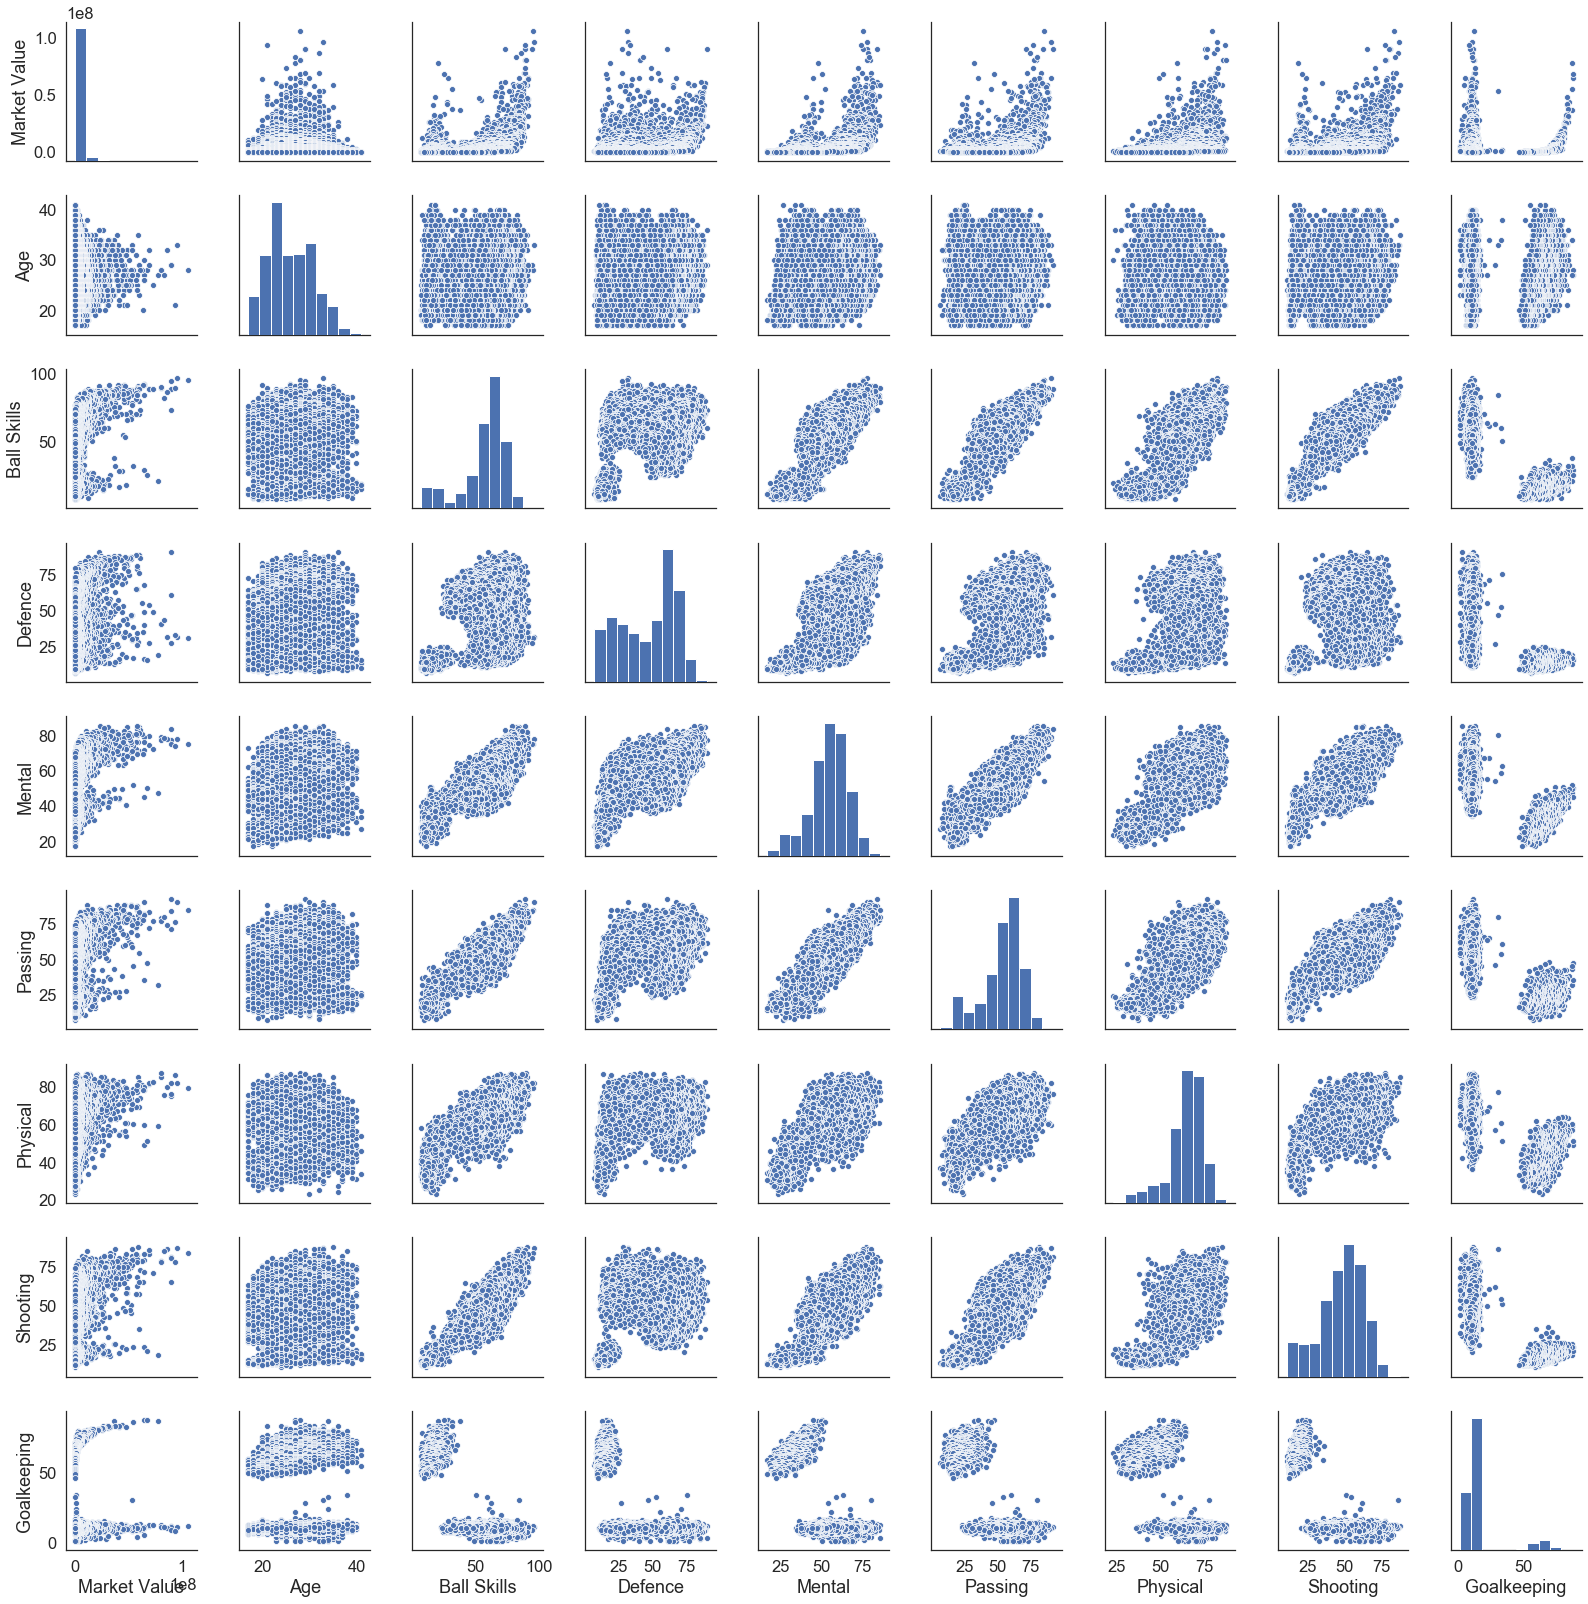

In [24]:
sns.set(style='white',font_scale=1.5)
sns.pairplot(df)

In [25]:

y, X = patsy.dmatrices("Q('Market Value') ~ Age + Q('Ball Skills') + Defence + Mental + Passing + Physical + Shooting + Goalkeeping", data=df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q('Market Value')   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     1114.
Date:                Sat, 04 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:38:51   Log-Likelihood:            -3.2471e+05
No. Observations:               19386   AIC:                         6.494e+05
Df Residuals:                   19377   BIC:                         6.495e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.777e+07   3.71e+05    -47.847      0.000   -1.85e+07    -1.7e+07
Age              -2.363e+05   8382.446    -28.185      0.000   -2.53e+05    -2.2e+05
Q('Ball Skills')  7.215e+04   7551.270      9.555      0.000    5.73e+04     8.7e+04
Defence           4081.6875   3711.427      1.100      0.271   -3193.031    1.14e+04
Mental             3.04e+05   9147.664     33.233      0.000    2.86e+05    3.22e+05
Passing          -3.266e+04   6695.631     -4.878      0.000   -4.58e+04   -1.95e+04
Physical          1.809e+04   5913.850      3.059      0.002    6496.054    2.97e+04
Shooting            5.4e+04   6409.178      8.425      0.000    4.14e+04    6.66e+04
Goalkeeping        2.16e+05   4318.103     50.028      0.000    2.08e+05    2.24e+05
==============================================================================
Omnibus:                    24748.425   Durbin-Watson:                   0.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5844833.308
Skew:                           6.993   Prob(JB):                         0.00
Kurtosis:                      86.907   Cond. No.                     1.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
df1 = df.copy()

In [27]:
df1['Market Value'] = np.log(df['Market Value'])

In [28]:
df1 = df1.rename(columns={'Market Value':'Log Market Value'})

In [29]:
df1 = df1.drop('Mental',axis=1)
df1 = df1.drop('Ball Skills',axis=1)

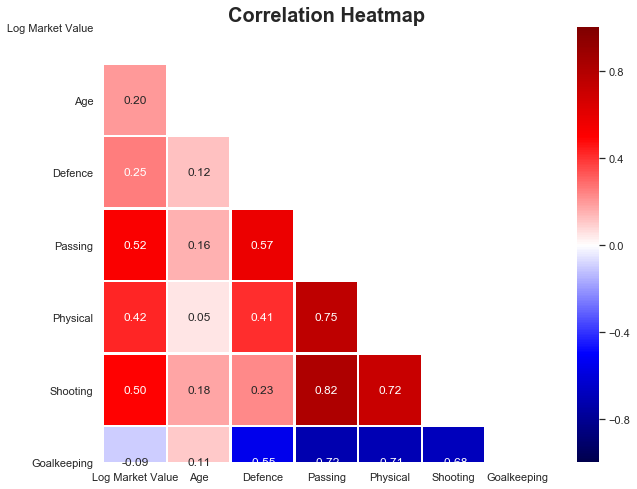

In [30]:
sns.set(font_scale=1,style='white')
corr_matrix = df1.corr()
fig = plt.figure(figsize=[10,8])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1.5,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20)

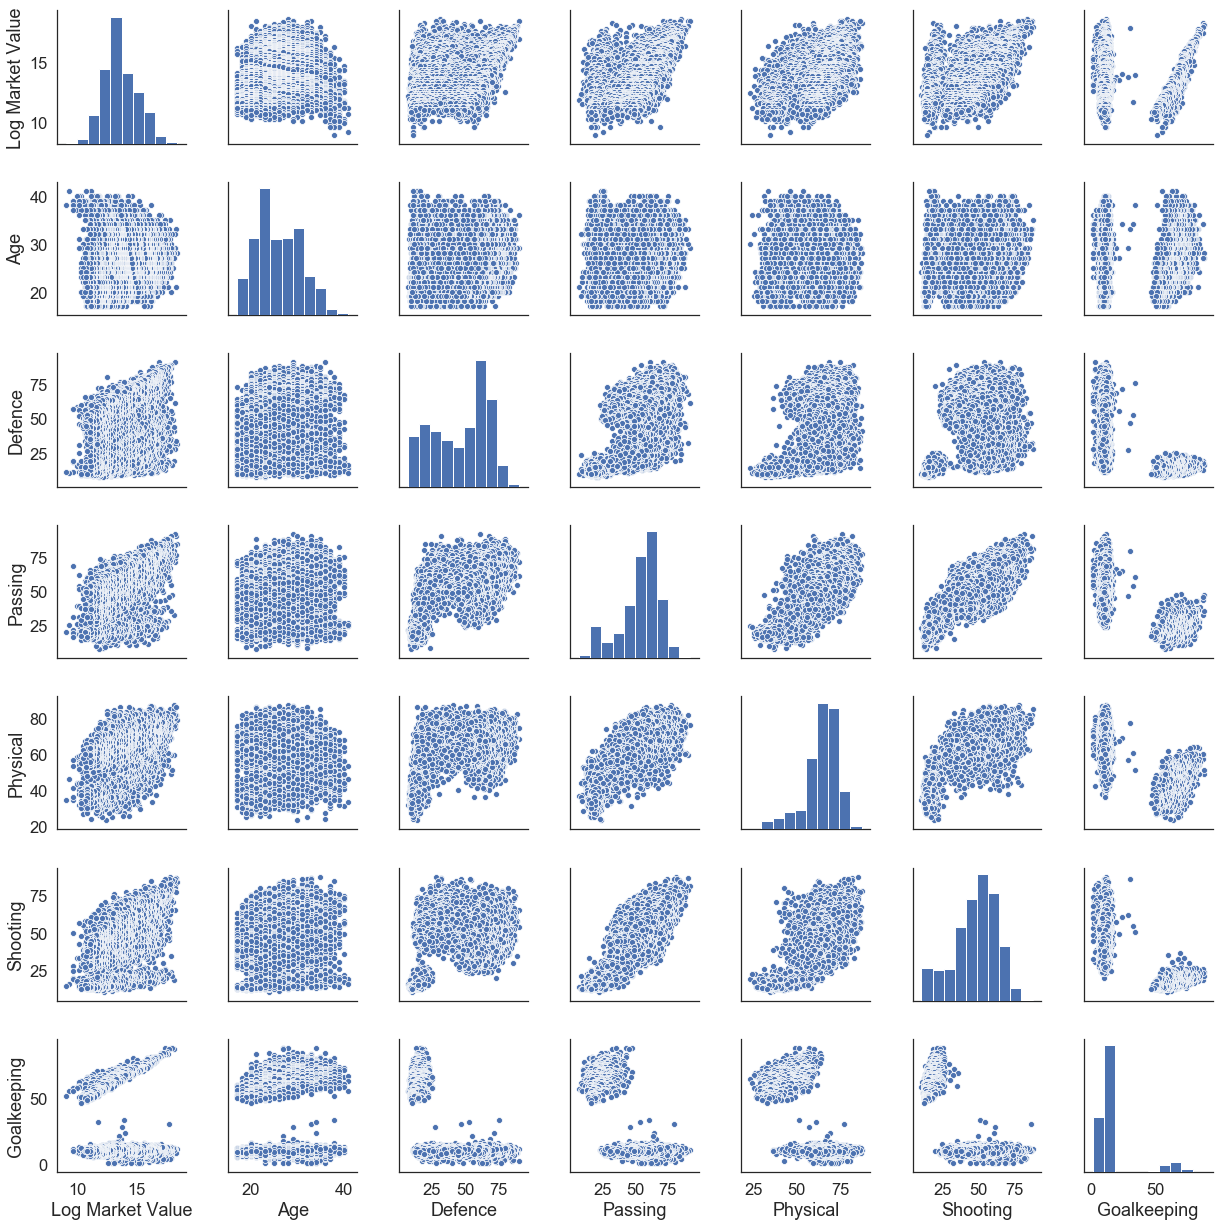

In [31]:
sns.set(style='white',font_scale=1.5)
sns.pairplot(df1)

In [32]:
y, X = patsy.dmatrices("Q('Log Market Value') ~ Age + Defence + Passing + Physical + Shooting + Goalkeeping", data=df1, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Q('Log Market Value')   R-squared:                       0.583
Model:                               OLS   Adj. R-squared:                  0.583
Method:                    Least Squares   F-statistic:                     4523.
Date:                   Sat, 04 Sep 2021   Prob (F-statistic):               0.00
Time:                           13:45:09   Log-Likelihood:                -25368.
No. Observations:                  19386   AIC:                         5.075e+04
Df Residuals:                      19379   BIC:                         5.080e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.1010      0.072     70.793      0.000       4.960       5.242
Age            -0.0412      0.002    -26.196      0.000      -0.044      -0.038
Defence         0.0284      0.001     55.178      0.000       0.027       0.029
Passing         0.0194      0.001     18.446      0.000       0.017       0.021
Physical        0.0402      0.001     37.201      0.000       0.038       0.042
Shooting        0.0691      0.001     68.165      0.000       0.067       0.071
Goalkeeping     0.0829      0.001    115.059      0.000       0.081       0.084
==============================================================================
Omnibus:                      440.831   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.935
Skew:                           0.365   Prob(JB):                    7.40e-104
Kurtosis:                       3.237   Cond. No.                     1.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(pred,y,alpha=0.1)
    plt.plot(y, y, color='red',linewidth=1,)
    plt.title("Regression fit")
    plt.xlabel("Predicted y")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res,alpha=0.1)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    print(res)    
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt,)
    plt.title("Normal Q-Q plot")

In [34]:
y = df1['Log Market Value']
X = df1.drop(['Player','Log Market Value'],axis=1)

0        1.768813
1        1.425493
2        2.039495
3        1.974358
4        2.122271
           ...   
19397   -0.578451
19398   -1.203829
19399   -0.814715
19400   -0.995620
19401   -0.121899
Name: Log Market Value, Length: 19386, dtype: float64


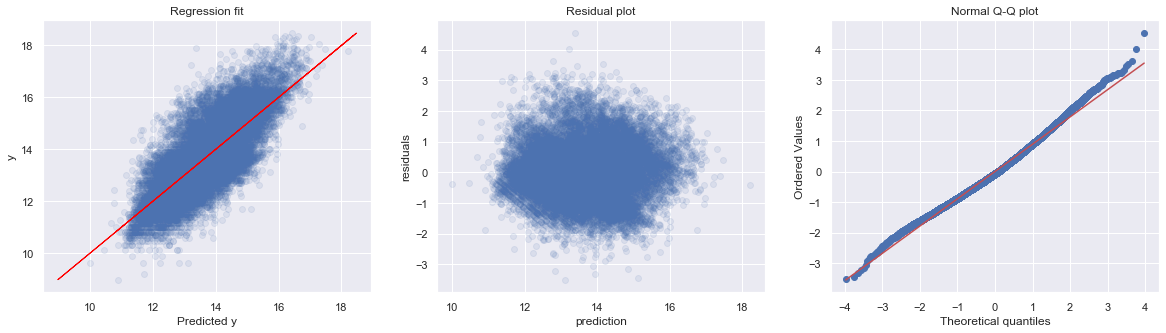

In [35]:
sns.set(style='darkgrid')
diagnostic_plot(X, y)

In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [37]:
selected_columns = ['Age','Defence','Passing','Physical','Shooting','Goalkeeping']

In [38]:
# doing feature selection with Lasso
lasso_model = Lasso(alpha = 0.1)    
lasso_model.fit(X_train_val[selected_columns], y_train_val)
list(zip(selected_columns, lasso_model.coef_))

[('Age', -0.03256450686543371),
 ('Defence', 0.027131840608116624),
 ('Passing', 0.019373287385754497),
 ('Physical', 0.0391339894661407),
 ('Shooting', 0.06655454787927165),
 ('Goalkeeping', 0.07937171007918886)]

In [39]:
# Scaling x values for lasso,ridge,elastic net
std = StandardScaler()
std.fit(X_train_val.values)
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [41]:
# finding alpha value that gives lowest MAE for Lasso CV
alphavec = 10**np.linspace(-15,4,400)
lasso_model = LassoCV(alphas = alphavec, cv=kf)
lasso_model.fit(X_tr, y_train_val)
lasso_model.alpha_

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.248800842071432, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.589502359685866, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.246943062329592, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge.

6.449466771037634e-14

In [42]:
# finding alpha value that gives lowest MAE for Ridge CV
alphavec = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphavec, cv=kf)
ridge_model.fit(X_tr, y_train_val)
ridge_model.alpha_

0.01

In [43]:
# finding coefficients for optimum alpha value for Ridge
list(zip(X_train_val.columns, ridge_model.coef_))

[('Age', -0.19186546429259463),
 ('Defence', 0.5881040945480208),
 ('Passing', 0.2773653498030474),
 ('Physical', 0.4072505995033036),
 ('Shooting', 1.0401782222145408),
 ('Goalkeeping', 1.4151388109865928)]

In [44]:
# scoring the Ridge model based on CV
ridge_model_final = Ridge(alpha = 0.9329304026284686) 
Mean_R2_Ridge_CV = np.mean(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='r2'))
Mean_R2_Ridge_CV

0.5878473861422584

In [45]:
Std_R2_Ridge_CV = np.std(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='r2'))
Std_R2_Ridge_CV

0.012128716302272531

In [46]:
# scoring the Ridge model based on CV
Mean_MAE_Ridge_CV = -np.mean(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Mean_MAE_Ridge_CV

0.7073122522888833

In [47]:
Std_MAE_Ridge_CV = np.std(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Std_MAE_Ridge_CV

0.011465339370715307

In [48]:
## finding alpha value that gives lowest MAE for ElasticNet CV
alphavec = 10**np.linspace(-22,-17,300)
elastic_model = ElasticNetCV(alphas = alphavec, cv=kf)
elastic_model.fit(X_tr, y_train_val)
elastic_model.alpha_

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4399.891604122441, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4643.836619413372, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4568.293824588921, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4841.8803147617955, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4765.375712229011, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4851.634104950607, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. 

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4871.525166061942, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4871.919863136482, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4880.477138002113, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4881.969221849311, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4881.970197372056, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4881.908095037897, tolerance: 2.4044392252554463
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4649.580293550331, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4643.750699853178, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4595.974894770064, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4853.597678872717, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4850.179542935433, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4856.472306288504, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4891.777883161252, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4891.797786454654, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4891.572904834324, tolerance: 2.3806313878194967
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4321.207180365783, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4303.010457483954, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4644.849245165369, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4931.386597905504, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4944.645305134229, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4945.109230998285, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4956.40483678488, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4956.425418941527, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4956.445202654094, tolerance: 2.3966492546617375
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Yo

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4657.968449726834, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4665.7165127956105, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4640.651284100724, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. 

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4944.960396667699, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4940.112324319585, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4947.286821413466, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.153438573797, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.26519496926, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.131797613579, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Yo

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.430929890504, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.447540115575, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976.437955532135, tolerance: 2.4009087146261447
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. Y

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4632.34131848016, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4576.345578193769, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4678.198567379269, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You m

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4972.466483479556, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4973.908237149398, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4969.455254644619, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You 

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4977.928869418487, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4977.830202356302, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4977.935610825997, tolerance: 2.413999743803689
  tol, rng, random, positive)
C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You 

C:\Users\Sharvan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6172.051181793767, tolerance: 2.9992174611212934
  positive)


2.350917875457294e-21

In [49]:
# scoring the LR model based on CV
lm = LinearRegression()

Mean_R2_Linear_CV = np.mean(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='r2'))
Mean_R2_Linear_CV 

0.5878475608235643

In [50]:
Std_R2_Linear_CV = np.std(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='r2'))
Std_R2_Linear_CV

0.012129790381576216

In [51]:
Mean_MAE_Linear_CV = - np.mean(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Mean_MAE_Linear_CV

0.7073069784437764

In [52]:
Std_MAE_Linear_CV = np.std(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Std_MAE_Linear_CV

0.011462277812585077

In [53]:
X_train_val = X_train_val.reset_index().drop('index',axis=1)
y_train_val = y_train_val.reset_index().drop('index',axis=1)

In [54]:
err_vector = []

for degree in range(2,7):
    mae = []
    for train_index, test_index in kf.split(X_train_val):
        
        X_train1, X_test1 = X_train_val.loc[train_index], X_train_val.loc[test_index]
        y_train1, y_test1 = y_train_val.loc[train_index], y_train_val.loc[test_index]        
        
        poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        poly.fit(X_train1,y_train1)
        
        predict = poly.predict(X_test1)
        mae.append(mean_absolute_error(y_test1, predict))
    err_vector.append(np.mean(mae))
    print(degree)

2
3
4
5
6


In [55]:
err_vector

[0.4348251226607496,
 0.3676734823924675,
 0.3535292108845562,
 0.34693353090603857,
 0.36153683092155847]

In [56]:
poly = make_pipeline(PolynomialFeatures(4), LinearRegression())

Mean_R2_Poly_CV = np.mean(cross_val_score(poly, X_train_val, y_train_val, cv=kf, scoring='r2'))
Mean_R2_Poly_CV

0.890352128563768

In [57]:
Std_R2_Poly_CV = np.std(cross_val_score(poly, X_train_val, y_train_val, cv=kf, scoring='r2'))
Std_R2_Poly_CV

0.00134500064996857

In [58]:
Mean_MAE_Poly_CV =  - np.mean(cross_val_score(poly, X_train_val, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Mean_MAE_Poly_CV

0.3535292108845562

In [59]:
Std_MAE_Poly_CV = np.std(cross_val_score(poly, X_train_val, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Std_MAE_Poly_CV

0.002002697377486996

In [60]:
print(f'Mean R2 Linear is: {Mean_R2_Linear_CV:.3f} +- {Std_R2_Linear_CV:.3f}')
print(f'Mean R2 Ridge is: {Mean_R2_Ridge_CV:.3f} +- {Std_R2_Ridge_CV:.3f}')
print(f'Mean R2 Poly is: {Mean_R2_Poly_CV:.3f} +- {Std_R2_Poly_CV:.3f}')

Mean R2 Linear is: 0.588 +- 0.012
Mean R2 Ridge is: 0.588 +- 0.012
Mean R2 Poly is: 0.890 +- 0.001


In [62]:
print(f'Mean MAE Linear is: {Mean_MAE_Linear_CV:.3f} +- {Std_MAE_Linear_CV:.3f}')
print(f'Mean MAE Ridge is: {Mean_MAE_Ridge_CV:.3f} +- {Std_MAE_Ridge_CV:.3f}')
print(f'Mean MAE Poly is: {Mean_MAE_Poly_CV:.3f} +- {Std_MAE_Poly_CV:.3f}')

Mean MAE Linear is: 0.707 +- 0.011
Mean MAE Ridge is: 0.707 +- 0.011
Mean MAE Poly is: 0.354 +- 0.002


In [63]:
poly = make_pipeline(PolynomialFeatures(4), LinearRegression())
poly.fit(X_train_val,y_train_val)
predicted = poly.predict(X_test)
print('R2 score on test set is: {}'.format(r2_score(y_test, predicted)))
print('MSE score on test set is: {}'.format(mean_absolute_error(y_test, predicted)))

R2 score on test set is: 0.8868254795743035
MSE score on test set is: 0.3521919252222999


In [64]:
def diagnostic_plot2(x_train, y_train, x_test, y_test):
    plt.figure(figsize=(22,8))
    
  #  poly = make_pipeline(PolynomialFeatures(4), LinearRegression())
  #  poly.fit(x_train,y_train)
  #  pred = poly.predict(x_test)
    
    rgr = LinearRegression()
    rgr.fit(x_train,y_train)
    pred = rgr.predict(x_test)    

    plt.subplot(1, 2, 1)
    plt.scatter(pred,y_test,alpha=0.1)
    plt.plot(y_test, y_test, color='red',linewidth=1,label='Identity Line (Log Market Value)')
    plt.title("Regression Fit on Test Set",weight='bold')
    plt.xlabel("Log Predicted Market Value")
    plt.ylabel("Log Market Value")
    plt.legend(loc='lower right')
    sns.despine()
    
    plt.subplot(1, 2, 2)
    res = np.array(y_test).reshape(-1,1) - pred
    plt.scatter(pred, res,alpha=0.1)
    plt.title("Residual Plot on Test Set",weight='bold')
    plt.xlabel("Log Predicted Market Value")
    plt.ylabel("Residuals")
    sns.despine()
    
 #   plt.subplot(1, 3, 3)
 #   #Generates a probability plot of sample data against the quantiles of a 
 #   # specified theoretical distribution 
 #   stats.probplot(res.T[0], dist="norm", plot=plt,)
 #   plt.title("Normal Q-Q plot")

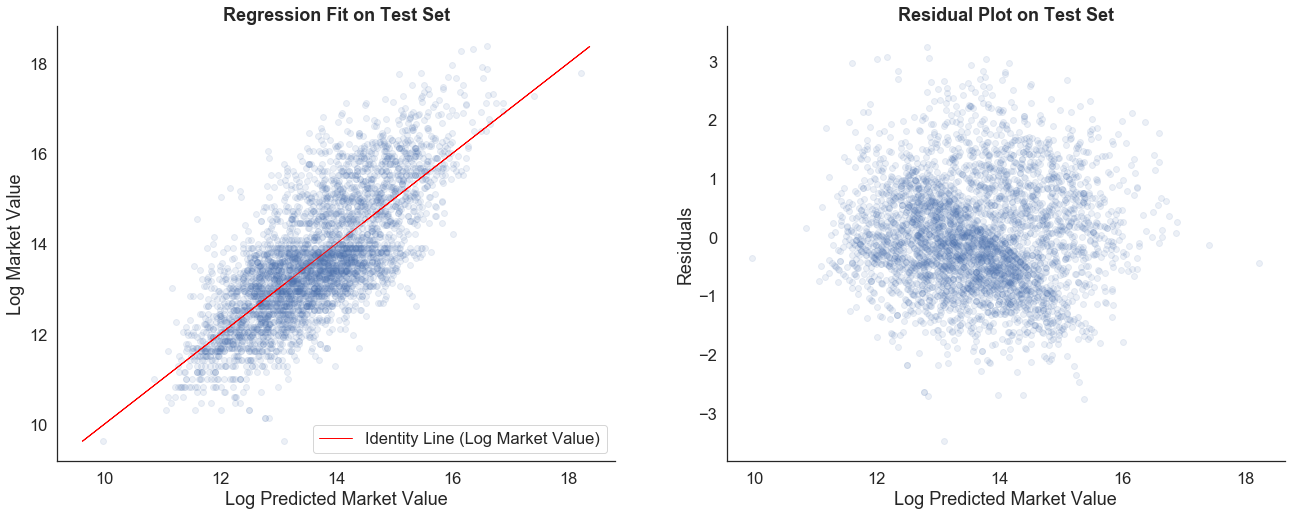

In [65]:
sns.set(style='white',font_scale=1.5)
diagnostic_plot2(X_train_val, y_train_val,X_test,y_test)

In [66]:
poly = make_pipeline(PolynomialFeatures(4), LinearRegression())
poly.fit(X_train_val,y_train_val)
predicted = poly.predict(X_test)
predicted

array([[13.86684301],
       [14.86446469],
       [14.12654845],
       ...,
       [13.30539012],
       [12.22618497],
       [12.91099057]])

In [67]:
Test_Set = pd.DataFrame(y_test).join(X_test).join(pd.DataFrame(df1['Player']))
Test_Set['Log Market Value'] = np.exp(Test_Set['Log Market Value'] )
Test_Set = Test_Set.rename(columns={'Log Market Value':'Market Value'})
Test_Set['Predicted Market Value'] = np.exp(predicted)
Test_Set = Test_Set.sort_values(by='Predicted Market Value',ascending=False)
#Test_Set['Market Value'] = Test_Set['Market Value'].apply(lambda x : "{:,}".format(int(x)))
#Test_Set['Predicted Market Value'] = Test_Set['Predicted Market Value'].apply(lambda x : "{:,}".format(int(x)))
Test_Set = Test_Set[['Player','Market Value','Predicted Market Value','Age','Defence','Passing','Physical','Shooting','Goalkeeping']]
Test_Set.reset_index(inplace=True)
Test_Set.drop('index',axis=1,inplace=True)
Test_Set

,Player,Market Value,Predicted Market Value,Age,Defence,Passing,Physical,Shooting,Goalkeeping
0,Robert Lewandowski,86000000.0,1.122529e+08,32,31.666667,74.333333,80.000000,86.250,10.2
1,Virgil van Dijk,90000000.0,1.042331e+08,29,90.666667,71.666667,74.857143,65.125,11.6
2,Lionel Messi,95500000.0,9.119414e+07,33,32.000000,90.666667,82.000000,86.875,10.8
3,Paul Pogba,58000000.0,7.823229e+07,27,65.000000,85.333333,77.142857,82.000,4.0
4,Bernardo Silva,64000000.0,7.118480e+07,26,49.333333,82.333333,78.142857,71.375,10.8
...,...,...,...,...,...,...,...,...,...
3873,Sam Russell,25000.0,3.251109e+04,37,25.000000,30.666667,42.428571,19.625,58.4
3874,Hüseyin Altıntaş,30000.0,3.098759e+04,25,8.666667,16.333333,32.428571,14.000,50.4
3875,Joe Murphy,30000.0,2.647249e+04,39,18.000000,26.333333,41.857143,18.500,60.6
3876,Joel Pinto,25000.0,2.567499e+04,40,11.666667,26.000000,56.428571,17.375,60.4


In [68]:
mean_absolute_error(Test_Set['Market Value'],Test_Set['Predicted Market Value'])

837072.5083868826

In [69]:
r2_score(Test_Set['Market Value'],Test_Set['Predicted Market Value'])

0.8114669641813844

In [70]:
stats.kurtosis(Test_Set['Market Value']-Test_Set['Predicted Market Value'])

106.60095932801262

In [71]:
def diagnostic_plot3(x_train, y_train, x_test, y_test):
    plt.figure(figsize=(22,8))
    
    poly = make_pipeline(PolynomialFeatures(4), LinearRegression())
    poly.fit(x_train,y_train)
    pred = poly.predict(x_test)

    plt.subplot(1, 2, 1)
    plt.scatter(np.exp(pred),np.exp(y_test),alpha=0.1)
    plt.plot(np.exp(y_test), np.exp(y_test), color='red',linewidth=1,label='Identity Line (Market Value)')
    plt.title("Regression Fit on Test Set",weight='bold')
    plt.xlabel("Predicted Market Value")
    plt.ylabel("Market Value")
    plt.legend()
    sns.despine()
    
    plt.subplot(1, 2, 2)
    res = np.exp(np.array(y_test)).reshape(-1,1) - np.exp(pred)
    plt.scatter(np.exp(pred), res,alpha=0.1)
    plt.title("Residual Plot on Test Set",weight='bold')
    plt.xlabel("Predicted Market Value")
    plt.ylabel("Residuals")
    sns.despine()

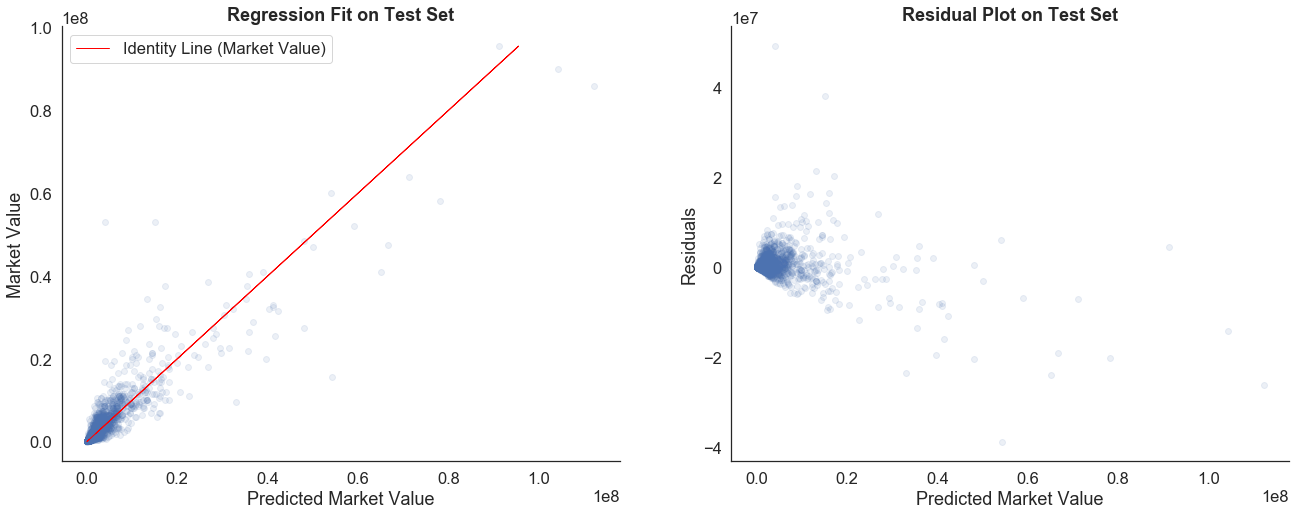

In [72]:
sns.set(style='white',font_scale=1.5)
diagnostic_plot3(X_train_val, y_train_val,X_test,y_test)

In [73]:
Test_Set['Market Value'] = Test_Set['Market Value'].apply(lambda x : "{:,}".format(int(x)))
Test_Set['Predicted Market Value'] = Test_Set['Predicted Market Value'].apply(lambda x : "{:,}".format(int(x)))
Test_Set[['Defence','Passing','Physical','Shooting','Goalkeeping']] = Test_Set[['Defence','Passing','Physical','Shooting','Goalkeeping']].apply(lambda x: round(x,1))
Test_Set = Test_Set.rename(columns={'Market Value':'Market Value (Euros)','Predicted Market Value': 'Predicted Market Value (Euros)'})
Test_Set

,Player,Market Value (Euros),Predicted Market Value (Euros),Age,Defence,Passing,Physical,Shooting,Goalkeeping
0,Robert Lewandowski,"86,000,000","112,252,933",32,31.7,74.3,80.0,86.2,10.2
1,Virgil van Dijk,"89,999,999","104,233,097",29,90.7,71.7,74.9,65.1,11.6
2,Lionel Messi,"95,499,999","91,194,139",33,32.0,90.7,82.0,86.9,10.8
3,Paul Pogba,"57,999,999","78,232,290",27,65.0,85.3,77.1,82.0,4.0
4,Bernardo Silva,"64,000,000","71,184,803",26,49.3,82.3,78.1,71.4,10.8
...,...,...,...,...,...,...,...,...,...
3873,Sam Russell,"25,000","32,511",37,25.0,30.7,42.4,19.6,58.4
3874,Hüseyin Altıntaş,"30,000","30,987",25,8.7,16.3,32.4,14.0,50.4
3875,Joe Murphy,"30,000","26,472",39,18.0,26.3,41.9,18.5,60.6
3876,Joel Pinto,"25,000","25,674",40,11.7,26.0,56.4,17.4,60.4
